# Pipeline for the anomaly detection on the SKAB using VAE

In [1]:
# libraries importing
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# additional modules
import sys
sys.path.append('../utils')
from evaluating import evaluating_change_point

## Data loading

In [2]:
# benchmark files checking
all_files=[]
import os
for root, dirs, files in os.walk("../data/"):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))

In [3]:
# datasets with anomalies loading
list_of_df = [pd.read_csv(file, 
                          sep=';', 
                          index_col='datetime', 
                          parse_dates=True) for file in all_files if 'anomaly-free' not in file]
# anomaly-free df loading
anomaly_free_df = pd.read_csv([file for file in all_files if 'anomaly-free' in file][0], 
                            sep=';', 
                            index_col='datetime', 
                            parse_dates=True)

## Data description and visualization

In [4]:
# dataset characteristics printing
print(f'A number of datasets in the SkAB v1.0: {len(list_of_df)}\n')
print(f'Shape of the random dataset: {list_of_df[0].shape}\n')
n_cp = sum([len(df[df.changepoint==1.]) for df in list_of_df])
n_outlier = sum([len(df[df.anomaly==1.]) for df in list_of_df])
print(f'A number of changepoints in the SkAB v1.0: {n_cp}\n')
print(f'A number of outliers in the SkAB v1.0: {n_outlier}\n')
print(f'Head of the random dataset:')
display(list_of_df[0].head())

A number of datasets in the SkAB v1.0: 34

Shape of the random dataset: (1154, 10)

A number of changepoints in the SkAB v1.0: 130

A number of outliers in the SkAB v1.0: 13241

Head of the random dataset:


Accelerometer1RMS  Accelerometer2RMS   Current  Pressure  \
datetime                                                                        
2020-03-09 12:14:36           0.027429           0.040353  0.770310  0.382638   
2020-03-09 12:14:37           0.027269           0.040226  1.096960  0.710565   
2020-03-09 12:14:38           0.027040           0.039773  1.140150  0.054711   
2020-03-09 12:14:39           0.027563           0.040313  1.108680 -0.273216   
2020-03-09 12:14:41           0.026570           0.039566  0.704404  0.382638   

                     Temperature  Thermocouple  Voltage  Volume Flow RateRMS  \
datetime                                                                       
2020-03-09 12:14:36      71.2129       25.0827  219.789              32.0000   
2020-03-09 12:14:37      71.4284       25.0863  233.117              32.0104   
2020-03-09 12:14:38      71.3468       25.0874  234.745              32.0000   
2020-03-09 12:14:39      71.3258       25.0897  205.254              32.0104   
2020-03-09 12:14:41      71.2725       25.0831  212.095              33.0000   

                     anomaly  changepoint  
datetime                                   
2020-03-09 12:14:36      0.0          0.0  
2020-03-09 12:14:37      0.0          0.0  
2020-03-09 12:14:38      0.0          0.0  
2020-03-09 12:14:39      0.0          0.0  
2020-03-09 12:14:41      0.0          0.0

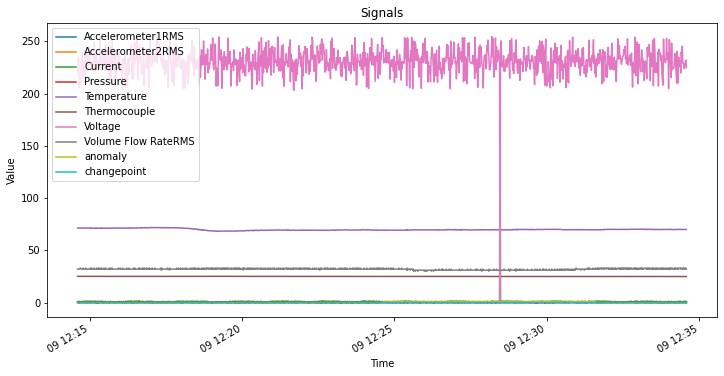

In [5]:
# random dataset visualizing
list_of_df[0].plot(figsize=(12,6))
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Signals')
plt.show()

## Labels

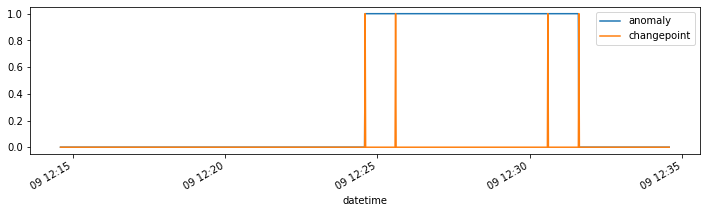

In [6]:
# plotting the labels both for outlier and changepoint detection problems
list_of_df[0].anomaly.plot(figsize=(12,3))
list_of_df[0].changepoint.plot()
plt.legend()
plt.show()

## Method applying

In [7]:
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, LSTM, RepeatVector
from tensorflow.keras.layers import Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras import losses
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.signal import medfilt
from sklearn import decomposition
from sklearn.model_selection import train_test_split

import numpy as np

from sklearn.preprocessing import StandardScaler

from itertools import product

In [8]:
# Function for repeatability
def Random(seed_value):
    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    import os
    os.environ['PYTHONHASHSEED']=str(seed_value)

    # 2. Set `python` built-in pseudo-random generator at a fixed value
    import random
    random.seed(seed_value)

    # 3. Set `numpy` pseudo-random generator at a fixed value
    import numpy as np
    np.random.seed(seed_value)

    # 4. Set `tensorflow` pseudo-random generator at a fixed value
    import tensorflow as tf
    tf.random.set_seed(seed_value)

# Opportunity to contribute

Helpful materials:
- https://thingsolver.com/time-series-anomaly-detection-using-a-variational-autoencoder-vae/
- https://github.com/keras-team/keras-io/blob/master/examples/generative/vae.py
- https://www.tensorflow.org/tutorials/generative/autoencoder
- https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb
- https://github.com/keras-team/keras/blob/keras-2/examples/variational_autoencoder.py

In [ ]:
def create_vae(input_dim, 
    batch_size, 
    intermediate_dim, 
    latent_dim,
    epsilon_std):
    
    #todo
    
    return vae, encoder, generator

In [10]:
def arch(data):
    
    #todo
    
    return history, model

### Training in the beginning of each dataset

In [11]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

# hyperparameters selection
Q = 0.999 # quantile for upper control limit (UCL) selection

# inference
predicted_outlier, predicted_cp = [], []
for df in list_of_df:
    X_train = df[:400].drop(['anomaly', 'changepoint'], axis=1)
    
    # scaler init and fitting
    StSc = StandardScaler()
    StSc.fit(X_train)
    
    # convert into input/output
    X = StSc.transform(X_train)
    
    # model defining and fitting
    history, model = arch(X)
    
    # results predicting
    residuals = pd.DataFrame(StSc.transform(X_train) - model.predict(StSc.transform(X_train))).abs().sum(axis=1)
    UCL = residuals.quantile(Q)
    
    df_sc = StSc.transform(df.drop(['anomaly','changepoint'], axis=1))
    ae_residuals = df_sc - model.predict(df_sc)
    ae = pd.DataFrame(ae_residuals).abs().sum(axis=1)
    
    prediction = pd.Series((ae > 3/2*UCL).astype(int).values, 
                                index=df.index).fillna(0)
    
    # predicted outliers saving
    predicted_outlier.append(prediction)
    
    # predicted CPs saving
    prediction_cp = abs(prediction.diff())
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

ValueError: ('Error when checking model target: expected no data, but got:', array([[ 0.14336242, -0.21437812, -0.77086653, ...,  0.57160501,
        -0.95271795, -0.61428113],
       [-0.24423838, -0.30555175,  0.41459621, ...,  0.77054428,
         0.29866113, -0.59166427],
       [-0.80240301, -0.63091507,  0.57133932, ...,  0.83133128,
         0.45151566, -0.61428113],
       ...,
       [ 0.16818055,  0.25342603,  0.08408927, ..., -2.37380136,
        -0.40786855, -0.61428113],
       [-1.00946407, -0.34732768,  0.58019445, ..., -2.84904516,
        -0.4084319 , -0.58992451],
       [-0.40360971, -0.38090662,  0.91654433, ..., -2.41801008,
         1.35822092,  1.53693072]]))

### Results

In [ ]:
# true outlier indices selection
true_outlier = [df.anomaly for df in list_of_df]

predicted_outlier[0].plot(figsize=(12, 3), label='predictions', marker='o', markersize=5)
true_outlier[0].plot(marker='o', markersize=2)
plt.legend();

In [ ]:
# true changepoint indices selection
true_cp = [df.changepoint for df in list_of_df]

predicted_cp[0].plot(figsize=(12, 3), label='predictions', marker='o', markersize=5)
true_cp[0].plot(marker='o', markersize=2)
plt.legend();

## Metrics calculation

In [ ]:
# binary classification metrics calculation
binary = evaluating_change_point(true_outlier, predicted_outlier, metric='binary', numenta_time='30 sec')

In [ ]:
# average detection delay metric calculation
add = evaluating_change_point(true_cp, predicted_cp, metric='average_delay', numenta_time='30 sec')

In [ ]:
# nab metric calculation
nab = evaluating_change_point(true_cp, predicted_cp, metric='nab', numenta_time='30 sec')

## [Additional] localization